# Data Mining
## Practical Assignment 3

### Important Notes:
1. Submit through **Canvas** in electronic form before 11:59pm on Wednesday, May 20, 2020
2. No late homework will be accepted.
3. This is a group-of-two assignment
4. The submitted file should be in ipynb format
5. The assignment is worth it 10 points
6. **Please make sure you are in a group on canvas!**
7. Question can be asked on the discussion tab on canvas.
8. The indication **optional** means that the question is optional; you won't lose any points if you do not do that part of the assignment, nor will you gain if you do it.

### Software:
We will be using Python programming language throughout this course. Further we will be using:
+ IPython Notebooks (as an environment)
+ Numpy
+ Pandas
+ Scikit-learn


### Background:

This practical assignment will be covering clustering and working with text. 

For the assignment, please download the dataset on [Movies](https://drive.google.com/drive/folders/0B-zklbckv9CHMmhzSXRPMk9tSWs?usp=sharing).

The folder contains a number of files, of which you will be using two: plot_summaries.txt and movie.metadata.tsv. Both are tab separated files. The former, i.e. plot_summaries.txt, contains the plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary. The latter file, i.e. movie.metadata.tsv contains metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. Freebase is a knowledge base (similar to a database) that contains information about different Entities (including movies). The file is tab-separated with the following columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

The goal of this assignment will be to cluster movies.

**Important Note**: This third assignment is not as instructive as the first assignment. The first assignment guided you step-by-step through all the preprocessing, training-validation-testing setup, etc. This assignment does not do so, but it leaves it up to you to decide how to use the data and design your experiments.

### Part 1: Import the data

We import both files and performing a join (merging the two files) using the Wikipedia ID (WID) to match the movies that appear in summaries to those that appear in the metadata. If a movie does not appear in either file, it is not included in the final list.

In [1]:
import pandas as pd
metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep="\t", header = None,
                        names=['WID', 'FID', 'Name', 'Release', 'Revenue', 
                               'Runtime', 'Languages', 'Countries', 'Genres'])
summaries = pd.read_csv('MovieSummaries/plot_summaries.txt',sep="\t", header = None,
                         names=['WID', 'Text'])
films = pd.merge(metadata, summaries, on='WID')

A movie be have more than one genre. We extract the first genre that characterizes the movie. Some movies may not have any corresponing genres.

In [2]:
import ast

genres = []
for film in films.values:
    exist = False
    g = ast.literal_eval(film[8])
    # Get the first genre for this movie
    for key in g:
        exist = True
        genres.append(g[key])
        break
    # If there is no genre for this movie
    if exist is False:
        genres.append('')

Consider only movies in four genres: 'Drama', 'Comedy', 'Science Fiction', 'Action'. Then sort them by Revenue they had in the cinemas, and get the top 100 most popular ones.

In [3]:
# Merge the films with the genre into a single Dataframe
genres = pd.Series(genres, name='Genre')
films_genre = pd.concat([films, genres], axis=1)

# Get only movies about the four following genres
films_genre_ind = films_genre.set_index('Genre')
movie_genres = ['Drama', 'Comedy', 'Science Fiction', 'Action']
genre100 = pd.DataFrame()
for mg in movie_genres:
    genre100 = genre100.append(films_genre_ind.loc[mg])

# Get the top-100 of those
top100 = (genre100.sort_values(by='Revenue',ascending=False)[0:100]).reset_index()[['Name','Text','Genre']]


In [4]:
top100

,Name,Text,Genre
0,The Avengers,"The Asgardian Loki encounters the Other, the ...",Science Fiction
1,Harry Potter and the Deathly Hallows – Part 2,{{further2}} {{See also}} As Lord Voldemort r...,Drama
2,Star Wars Episode I: The Phantom Menace,The Galactic Republic is in a period of decli...,Science Fiction
3,Star Wars Episode III: Revenge of the Sith,"As the Clone Wars rage on, the Galactic Repub...",Science Fiction
4,E.T. the Extra-Terrestrial,The film opens in a California forest as a gro...,Science Fiction
...,...,...,...
95,Hope Floats,Birdee Pruitt is a Chicago housewife who is i...,Drama
96,Finding Forrester,The film opens with 16-year-old Jamal Wallace ...,Drama
97,The Grey,John Ralph Ottway works in Alaska killing the...,Action
98,The Ides of March,Stephen Meyers is the junior campaign manager...,Drama


In [5]:
# Look at the distribution of your movies in the dataset
print(top100['Genre'].value_counts())

Science Fiction    59
Drama              25
Comedy              9
Action              7
Name: Genre, dtype: int64


### Part 2: Turn movies into BoW and Topics representation (Lecture 7) (5pts)

Turn each movie plot summary (i.e. the 'Text' column in the top100 dataframe) into:

* **Bag-of-Words**

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
bow = vect.fit_transform(top100['Text'])



* **Bag-of-bigrams**

In [15]:
vect = CountVectorizer(ngram_range=(2,2))
bo2g = vect.fit_transform(top100['Text'])

* **Bag-of-ngrams (for n = 1 and 2)**

In [16]:
vect = CountVectorizer(ngram_range=(1,2))
bo12g = vect.fit_transform(top100['Text'])

* **TF-IDF values**

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(norm=None)
tfidf = vect.fit_transform(top100['Text'])

* **Topics**
    * Experiment with different number of topics and choose the one that satisfies you by inspecting the top-10 most important words in each topic.

In [205]:
from sklearn.decomposition import LatentDirichletAllocation
import mglearn.tools
import numpy as np

vect = CountVectorizer(stop_words='english')
bow = vect.fit_transform(top100['Text'])
n_components = 12
lda = LatentDirichletAllocation(n_components=n_components, learning_method="batch", max_iter=25, random_state=0)

document_topics = lda.fit_transform(bow)

# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

topics = []

# print out the 10 topics:
for topic in range(n_components):
    print(feature_names[sorting[topic][:10]])
    topics.append(feature_names[sorting[topic]])

['jamal' 'michael' 'forrester' 'philip' 'kate' 'sara' 'loki' 'skeeter'
 'team' 'vilain']
['marty' 'doc' 'biff' 'george' 'time' 'deveraux' 'future' 'planet' 'spock'
 'jennifer']
['louis' 'party' 'thomas' 'claudia' 'lestat' 'armand' 'soran' 'enterprise'
 'costa' 'jan']
['luke' 'vader' 'meyers' 'quaid' 'han' 'leia' 'white' 'jason' 'snow'
 'superman']
['doc' 'nell' 'marty' 'joey' 'albert' 'horse' 'slime' 'jerry'
 'ghostbusters' 'german']
['dave' 'mitch' 'snow' 'white' 'tells' 'joe' 'queen' 'ottway' 'father'
 'lilo']
['lewis' 'juni' 'imhotep' 'obi' 'wan' 'anakin' 'carmen' 'time' 'alexander'
 'wilbur']
['aaron' 'aldous' 'john' 'chuck' 'ted' 'jim' 'zohan' 'alien' 'rodney'
 'jill']
['creature' 'andrew' 'pokémon' 'alien' 'gang' 'du' 'ash' 'father'
 'friends' 'time']
['brian' 'doug' 'thornton' 'father' 'jordan' 'richard' 'susan' 'amelia'
 'gon' 'qui']
['loveless' 'west' 'harry' 'ben' 'jake' 'gordon' 'balthazar' 'dave'
 'boris' 'voldemort']
['peter' 'david' 'ethan' 'max' 'megamind' 'einon' 'ángel

### Part 3: Clustering (Lecture 6) (5pts)

Cluster the movies using the k-means algorithm.

**Important Note**: In order to allow you to work on Part 3, before Part 2, the [Movies](https://drive.google.com/drive/folders/0B-zklbckv9CHMmhzSXRPMk9tSWs?usp=sharing) folder also contains a comma-separated file, moviesrep.csv, that includes a representation I built for you from the movies plot summary. Each line corresponds to a vector representation (i.e. a set of features) for each movie and you can apply the clustering algorithm on this.

**k-means**

+ Choose the number of clusters you wish to find in the data (n_clusters)
+ Choose a text representation from Part 2
+ Run a k-means algorithm
+ Evaluate the quality of the algorithm using inertia_, silhouette_score, adjusted_mutual_info_score, and adjusted_rand_score
    + some of these metrics require the use of ground truth
    + use the genre of each movie as ground truth, i.e. the perfect clustering would be the one that clusters movies based on their genre

In [129]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# movie_vectors = pd.read_csv('MovieSummaries/moviesrep.csv',sep=",", header = None)
movie_vectors = bo2g
kmeans = KMeans(n_clusters=4)
y_pred = kmeans.fit_predict(movie_vectors)

inertia_score = kmeans.inertia_
print("Inertia = {}".format(inertia_score))

sil_score = silhouette_score(movie_vectors, y_pred)
print('Silhouette score = {}'.format(sil_score))

adj_mut_info_score = adjusted_mutual_info_score(y_pred,top100['Genre'], average_method="arithmetic")
print('Adjusted mutual info score = {}'.format(adj_mut_info_score))

adj_rand_score = adjusted_rand_score(y_pred,top100['Genre'])
print('Adjusted rand score = {}'.format(adj_rand_score))


Inertia = 88410.6185567009
Silhouette score = 0.09565896592638362
Adjusted mutual info score = 0.03516214217514869
Adjusted rand score = 0.0478722403116824


**Number of cluster**

* Change the value of n\_clusters and plot inertia_, silhouette_score, adjusted_mutual_info_score, and adjusted_rand_score as a function of n_clusters
* Explain what you observe in the plots.
* Do the same for each text representation from Part 2.
* Explain the differences across different representations if there are any

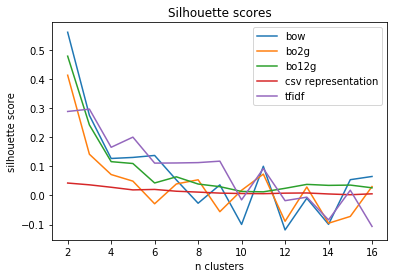

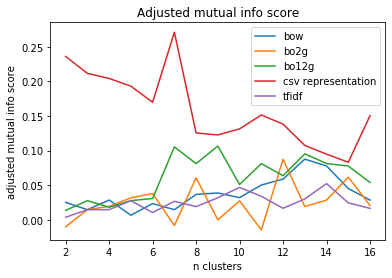

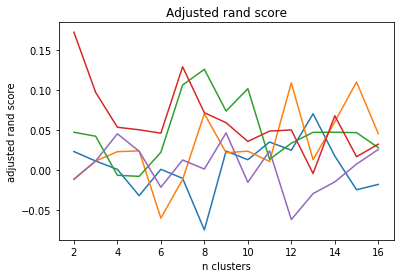

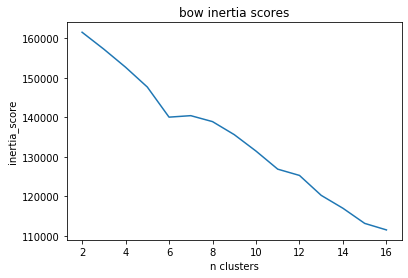

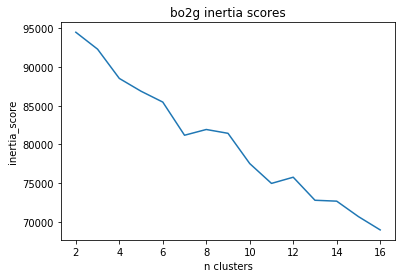

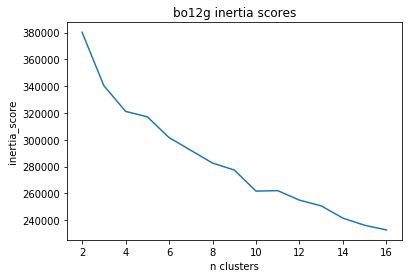

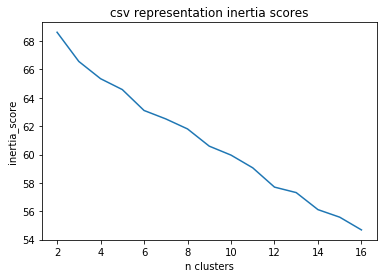

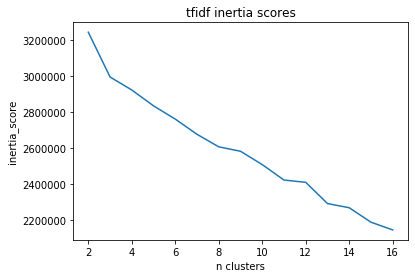

In [236]:
import matplotlib.pyplot as plt

def plot_scores_text_rep(movie_vectors, title, x):
    n_list = []
    inertia_list = []
    silhouette_list = []
    adj_mut_list = []
    adj_rand_list = []

    for n_clusters in range(15):
        n_clusters+=2
        n_list.append(n_clusters)
        kmeans = KMeans(n_clusters=n_clusters, random_state=1)
        y_pred = kmeans.fit_predict(movie_vectors)
        inertia_list.append(kmeans.inertia_)
        silhouette_list.append(silhouette_score(movie_vectors, y_pred))
        adj_mut_list.append(adjusted_mutual_info_score(y_pred,top100['Genre'], average_method="arithmetic"))
        adj_rand_list.append(adjusted_rand_score(y_pred,top100['Genre']))

    plt.figure(1)
    plt.plot(n_list, silhouette_list)
    plt.title('Silhouette scores')
    plt.xlabel('n clusters')
    plt.ylabel('silhouette score')

    plt.figure(2)
    plt.plot(n_list, adj_mut_list)
    plt.title('Adjusted mutual info score')
    plt.xlabel('n clusters')
    plt.ylabel('adjusted mutual info score')

    plt.figure(3)
    plt.plot(n_list, adj_rand_list)
    plt.title('Adjusted rand score')
    plt.xlabel('n clusters')
    plt.ylabel('adjusted rand score')

    plt.figure(x)
    plt.plot(n_list, inertia_list)
    plt.title(title + ' inertia scores')
    plt.xlabel('n clusters')
    plt.ylabel('inertia_score')

plot_scores_text_rep(bow,'bow', 4)
plot_scores_text_rep(bo2g,'bo2g', 5)
plot_scores_text_rep(bo12g,'bo12g', 6)
plot_scores_text_rep(pd.read_csv('MovieSummaries/moviesrep.csv',sep=",", header = None),'csv representation', 7)
plot_scores_text_rep(tfidf,'tfidf', 8)

for i in range(2):
    i+=1
    plt.figure(i)
    plt.legend(['bow','bo2g','bo12g','csv representation','tfidf'],loc='upper right')


BOW:
The inertia score of BOW does not show a clear elbow. However there are several points where the scores flatten out a little bit. The first point is a N = 4. Since you want to choose the lowest score with the least amount of clusters. This is the amount of clusters to go for.
For the silhouette scores, the scores start to descend very quickly from 2 to 4 clusters. However it peaks again at N = 7. 
For both the ARI and the AMI, the bow representation has its peak at n=9.
Regarding these evaluations, we would state that n=7 would be the optimal amount of clusters for the bow.

BO2G:
There is no clear elbow showing. The line is somewhat similar to the BOW, except for the fact that the inertia scores are quite a lot lower. Again at N = 4 the line of the scores seems to flatten out a little bit. Therefore it is wise to choose 4 clusters in this case as well.
Similar to BOW the scores silhouette scores descend real quick at the start, it peaks a little after the first initial drop at N = 6, followed by another drop. 
For the ARI and the AMI, the best n-value is n=12, so we are taking n=6, becaus it overall score the best at this number of clusters. Also the ARI and AMI are reasonably high at this point.

BO12G:
For the BO12G scores there is no elbow visible however compared to the previous two graphs, it looks more familiar to an elbow shape. In this case the point where to line seems to flatten is at N = 6. From this point on, the scores don't decrease as before. Thus it is a good idea to choose 6 clusters.
The BO12G silhouette scores graph shows an elbow like shape. Since for the silhouette scores you want to choose the highest score with the highest amount of cluster. The N will be fairly high for this representation. Since after N = 6, the graph nearly flattens out.
For the ARI the optimal value is at n=6 and for the AMI the optimal value is n=9. So for the bo12g, we will take n=6.

CSV Representation:
Our graph did not have an elbow, and looked more like a linear descending function. We did however spot a small dent in the graph at around n=5. So this is the best amount of clusters to choose.
This graph seems to be very flat so choosing from the silhouette score, but judging from a small dent, we would have to take n=12.
In the case of the AMI, it is best to take the n value at the peak of the AMI score, which, in our case, was at n=3. Often the AMI score at n = 3 was an improvement compared to the n =2 score, however after n = 3 it often had a steep downwards slope and thus lower score, so we will take n=3 for this one.
The ARI is at its best at n=4, where it peaks. A pattern in the ARI scores was a really high score at n = 2, with a massive drop at n = 3, which after n = 3 would rise again therefore, since having only 2 clusters would over generalize the data the optimal score in this case is n = 4.
In conclusion, for the representation taken from the csv, we will take n=9.

TF-IDF:
No elbow shape visible again. However at N=6 the graph flattens for a little bit. So this is the optimal amount of clusters to choose.
Similarly to the first two(BOW, BO2G) the slope of the descending graph is very steep at the start, after which a little peak can be seen. At N = 5 there is a peak after which the graph will only descend. So this is the best amount of clusters to choose.
For the AMI and ARI both, n=9 seems to be the optimal amount of clusters. So for the tfidf representation, we take n=9 as optimal cluster amount.

**Demonstrate clusters**

* for each representation choose the optimal number of clusters and repeat the k-means algorithm for that number of clusters
* print the top-10 most important words within each cluster
* print the titles of the movies for each cluster
* explain what you observe and whether results make sense

In [238]:
def k_means_topics_clusters(movie_vectors, n_components):
    lda = LatentDirichletAllocation(n_components=n_components, learning_method="batch", max_iter=25, random_state=0)

    document_topics = lda.fit_transform(movie_vectors)

    # for each topic (a row in the components_), sort the features (ascending).
    # Invert rows with [:, ::-1] to make sorting descending
    sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
    # print(len(lda.components_))
    # get the feature names from the vectorizer:
    # print(lda.components_[0])
    topics = []
    # print(feature_names[500:550])
    # print out the 10 topics:
    for topic in range(n_components):
        topicnames = []
        for name, topic_grades in zip(top100['Name'],document_topics):
            if np.argmax(topic_grades) == topic:
                topicnames.append(name)
        try:
            print('topic #',topic,feature_names[sorting[topic][:10]],'\nMovies: ',topicnames)
        except:
            print('topic #',topic, '\nMovies: ',topicnames)
    return 

print('bow, n_clusters = 7')
k_means_topics_clusters(bow, 7)
print('\ntfidf, n_clusters = 9')
k_means_topics_clusters(tfidf, 9)
print('\nbo2g, n_clusters = 6')
k_means_topics_clusters(bo2g, 6)
print('\nbo12g, n_clusters = 6')
k_means_topics_clusters(bo12g, 6)




bow, n_clusters = 7
topic # 0 ['jamal' 'michael' 'forrester' 'megamind' 'philip' 'kate' 'man' 'alien'
 'sara' 'loki'] 
Movies:  ['The Avengers', 'MegaMind', 'Chicken Little', 'Ghostbusters', 'The Expendables 2', 'Click', 'The Help', 'Flubber', 'Alien', "My Sister's Keeper", 'Finding Forrester']
topic # 1 ['marty' 'doc' 'aaron' 'aldous' 'harry' 'time' 'dave' 'balthazar' 'biff'
 'voldemort'] 
Movies:  ['Harry Potter and the Deathly Hallows – Part 2', 'Back to the Future', 'Close Encounters of the Third Kind', 'Back to the Future Part II', 'Superman', 'Good Will Hunting', "The Sorcerer's Apprentice", 'Universal Soldier', "The Time Traveler's Wife", 'Get Him to the Greek', 'Star Trek III: The Search for Spock']
topic # 2 ['louis' 'creature' 'brian' 'einon' 'gang' 'du' 'rodney' 'doug' 'bigweld'
 'party'] 
Movies:  ['Men in Black II', 'Robots', 'Interview with the Vampire: The Vampire Chronicles', 'Cocktail', 'Forever Young', 'Star Trek: Generations', 'Dragonheart', 'A Civil Action', 'Projec

For the bow, we found some inconsistencies, since some movies from the same series are in different clusters, however the words do correspond with the movies. In some cases several movies of the same series are clustered together. Also there seems to be a little overlap in the type of movies that are put together.
The bo2g seems to perform worse than the bow, because movies from the same series are spread across various clusters, more than with the bow. The cluster do however show some resemblance in the types of movies that are put together.
The bo12g performs well judging by the movies in the various clusters. Movies from the same series are also mostly in the same clusters, which indicates that the performance is better than the bow and bo2g. Which makes sense because the model takes both unigrams and bigrams into account. So word combinations like ‘Harry Potter’ are keywords which the model uses for grouping the series.
For the tfidf the words in the clusters show a large overlap, because these are unique words, which score high within each document that contains them. The model performs well in clustering series together. Also the clustering seems well. 
